# Import Libraries

In [1]:
! pip install opencv-python matplotlib numpy kagglehub

In [2]:
! pip install pytesseract pillow google-genai

In [3]:
!pip install pdf2image

In [4]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.10 [186 kB]
Fetched 186 kB in 1s (275 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126435 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.10_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.10) ...
Setting up poppler-utils (22.02.0-2ubuntu0.10) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
import kagglehub
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os

from PIL import Image
import pytesseract


from google import genai
from google.colab import userdata # colab only code
from PIL import Image
import json
import time
from pdf2image import convert_from_path


# Download Dataset from Kaggle

In [6]:


# Download latest version
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'resume-dataset' dataset.
Path to dataset files: /kaggle/input/resume-dataset


# Load Dataset

In [7]:
df = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')

df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [8]:
def display_image(image, title="Image"):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

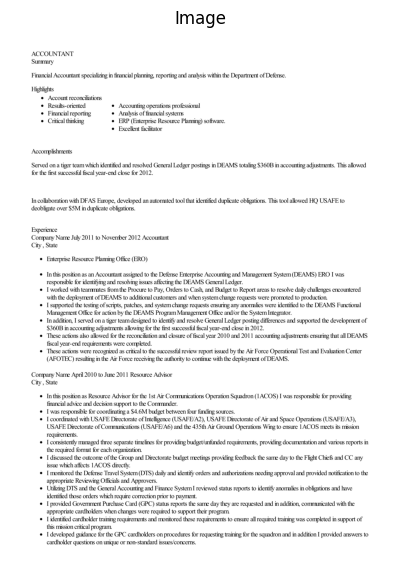

In [9]:


# Replace 'your_pdf_file.pdf' with the actual path to your PDF file
pdf_path = '/kaggle/input/resume-dataset/data/data/ACCOUNTANT/10554236.pdf'

# Convert the first page of the PDF to an image
images = convert_from_path(pdf_path, first_page=1, last_page=1)

# Access the first image (which is the only one since we only converted the first page)
first_page_image = images[0]

# You can now work with the 'first_page_image' which is a PIL Image object
# display(first_page_image)
display_image(np.array(first_page_image))

# Preprocess PDF's

#### Convert to Grayscale

In [10]:
# Convert the image to grayscale
def convert_to_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#### Noise (blur) Reduction

In [11]:
def reduce_noise(gray_image):
  return cv2.GaussianBlur(gray_image, (5, 5), 0)

#### Binarization (Thresholding)

In [12]:
def binarize_image(blur_reduced_image):
  return cv2.adaptiveThreshold(
    blur_reduced_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, # Invert the colors (text becomes white)
    11, # Block size
    4  # Constant C
  )

#### Skew Correction

In [13]:
def deskew_image(image):
    """
    Corrects the skew of an image by finding the minimum area rectangle
    of the text block and rotating accordingly.
    """
    # Find all non-zero (white) pixels
    coords = cv2.findNonZero(image)

    # Get the minimum area bounding rectangle
    # It returns (center(x,y), (width, height), angle of rotation)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1] - 90

    # The `cv2.minAreaRect` angle has a specific range.
    # We need to adjust it for our rotation.
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = angle

    # Get the rotation matrix and rotate the image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    print(f"Detected skew angle: {angle:.2f} degrees")

    # Now, rotate the original grayscale image by the same angle
    (h, w) = rotated.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_gray = cv2.warpAffine(rotated, M, (w, h),
                                  flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REPLICATE)

    return deskewed_gray

#### Combining grayscale, noise reduction, binarization, and deskew

In [14]:
def process_one_image(image):
  image = convert_to_grayscale(image)
  print("Converted image to grayscale..")
  image = reduce_noise(image)
  print("Reduced noise in the image..")
  image = binarize_image(image)
  print("Binarized the image..")
  image = deskew_image(image)
  print("Corrected image orientation..")
  return image

#### Load PDF's and Process

In [15]:
from pdf2image import convert_from_path
import os

# Define the input and output directories
input_dir = '/kaggle/input/resume-dataset/data/data'
output_dir = './processed_images'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Iterate through all subdirectories (categories) in the input directory
for category_dir in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category_dir)

    # Check if it's a directory
    if os.path.isdir(category_path):
        print(f"Processing category: {category_dir}")

        # Create a subdirectory for the category in the output directory
        output_category_dir = os.path.join(output_dir, category_dir)
        os.makedirs(output_category_dir, exist_ok=True)

        # Iterate through all PDF files in the category directory
        for pdf_file in os.listdir(category_path):
            if pdf_file.endswith('.pdf'):
                pdf_path = os.path.join(category_path, pdf_file)
                try:
                    # Convert the first page of the PDF to an image
                    images = convert_from_path(pdf_path, first_page=1, last_page=1)
                    if images:
                        first_page_image = images[0]

                        # Convert PIL image to numpy array for processing with OpenCV functions
                        image_np = np.array(first_page_image)

                        # Process the image using the defined function
                        processed_image = process_one_image(image_np)

                        # Define the output path for the processed image
                        output_filename = os.path.splitext(pdf_file)[0] + '.png' # Save as PNG
                        output_path = os.path.join(output_category_dir, output_filename)

                        # Save the processed image
                        cv2.imwrite(output_path, processed_image)
                        print(f"Processed and saved: {output_path}")

                except Exception as e:
                    print(f"Error processing {pdf_file}: {e}")

print("Finished processing all PDF files.")

Streaming output truncated to the last 5000 lines.
Processed and saved: ./processed_images/ADVOCATE/47133747.png
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: -0.06 degrees
Corrected image orientation..
Processed and saved: ./processed_images/ADVOCATE/23577836.png
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: -0.09 degrees
Corrected image orientation..
Processed and saved: ./processed_images/ADVOCATE/90468982.png
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Processed and saved: ./processed_images/ADVOCATE/14176254.png
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Processed and saved: ./processed_images/ADVOCATE/37640804.png
Converted image to grayscale..
Reduced noise in the i

# Text Extraction Using Tesseract

In [16]:
input_folder_path = "/content/processed_images"
output_folder_path = "/content/tesseract_output"
start_time = time.time()

if os.path.exists(output_folder_path):
  print(f"Output folder already exists: {output_folder_path}")
else:
  os.makedirs(output_folder_path)
  print(f"Created folder: {output_folder_path}")


# Calculate total images for progress tracking
total_images = 0
for category_dir in os.listdir(input_folder_path):
    category_path = os.path.join(input_folder_path, category_dir)
    if os.path.isdir(category_path):
        total_images += len(os.listdir(category_path))

print(f"Total images to process: {total_images}")

processed_count = 0
for category_dir in os.listdir(input_folder_path):
    category_path = os.path.join(input_folder_path, category_dir)

    if os.path.isdir(category_path):
        print(f"Processing category: {category_dir}")
        output_category_dir = os.path.join(output_folder_path, category_dir)
        os.makedirs(output_category_dir, exist_ok=True)

        for image_name in os.listdir(category_path):
            if image_name.endswith('.png'): # Assuming processed images are PNG
                processed_count += 1
                print(f"Processing image {processed_count}/{total_images}: {image_name}")
                image_path = os.path.join(category_path, image_name)
                print("Extracting text from image..")
                try:
                    text = pytesseract.image_to_string(Image.open(image_path))
                    output_path = os.path.join(output_category_dir, image_name.replace(".png", ".txt"))
                    with open(output_path, "w") as f:
                        f.write(text)
                    print(f"Saved extracted text to {output_path}")
                except Exception as e:
                    print(f"Error processing image {image_name}: {e}")
                print("-"*50)


print("Text Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Created folder: /content/tesseract_output
Total images to process: 2483
Processing category: DESIGNER
Processing image 1/2483: 28326441.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/DESIGNER/28326441.txt
--------------------------------------------------
Processing image 2/2483: 24285142.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/DESIGNER/24285142.txt
--------------------------------------------------
Processing image 3/2483: 51681660.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/DESIGNER/51681660.txt
--------------------------------------------------
Processing image 4/2483: 25061645.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/DESIGNER/25061645.txt
--------------------------------------------------
Processing image 5/2483: 14743911.png
Extracting text from image..
Saved extracted text to /content/tesseract_output/DESIGNER/14743911.txt

KeyboardInterrupt: 

In [17]:
# OPTIMIZED GOOGLE COLAB OCR CODE WITH PARALLEL PROCESSING
import os
import time
import multiprocessing as mp
from functools import partial
from PIL import Image
import pytesseract

def process_single_image(image_info, input_folder_path, output_folder_path):
    """Process a single image with OCR in parallel"""
    category_dir, image_name = image_info

    try:
        # Construct paths
        image_path = os.path.join(input_folder_path, category_dir, image_name)
        output_category_dir = os.path.join(output_folder_path, category_dir)

        # Ensure output directory exists (thread-safe)
        os.makedirs(output_category_dir, exist_ok=True)

        # Extract text using OCR
        with Image.open(image_path) as img:
            text = pytesseract.image_to_string(img)

        # Save extracted text
        output_path = os.path.join(output_category_dir, image_name.replace(".png", ".txt"))
        with open(output_path, "w", encoding='utf-8') as f:
            f.write(text)

        return (True, image_name, None)

    except Exception as e:
        return (False, image_name, str(e))

def collect_image_tasks(input_folder_path):
    """Collect all image processing tasks efficiently"""
    tasks = []

    for category_dir in os.listdir(input_folder_path):
        category_path = os.path.join(input_folder_path, category_dir)

        if os.path.isdir(category_path):
            for image_name in os.listdir(category_path):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
                    tasks.append((category_dir, image_name))

    return tasks

def process_images_optimized(input_folder_path="/content/processed_images",
                           output_folder_path="/content/tesseract_output",
                           num_processes=None):
    """MAIN OPTIMIZED FUNCTION - Replaces your original code"""
    start_time = time.time()

    # Create output folder
    os.makedirs(output_folder_path, exist_ok=True)
    print(f"Using output folder: {output_folder_path}")

    # Collect all image processing tasks
    print("Collecting image tasks...")
    tasks = collect_image_tasks(input_folder_path)
    total_images = len(tasks)

    print(f"Total images to process: {total_images}")

    if total_images == 0:
        print("No images found to process.")
        return

    # Determine optimal number of processes
    if num_processes is None:
        num_processes = min(mp.cpu_count(), 8, total_images)

    print(f"Using {num_processes} parallel processes")

    # Create partial function for multiprocessing
    process_func = partial(process_single_image,
                          input_folder_path=input_folder_path,
                          output_folder_path=output_folder_path)

    # Process images in parallel
    successful_count = 0
    failed_count = 0

    with mp.Pool(processes=num_processes) as pool:
        print("Starting parallel OCR processing...")

        for i, result in enumerate(pool.imap(process_func, tasks), 1):
            success, image_name, error = result

            if success:
                successful_count += 1
            else:
                failed_count += 1
                print(f"✗ Failed: {image_name} - Error: {error}")

            # Progress update every 10 images
            if i % 10 == 0 or i == total_images:
                progress = (i / total_images) * 100
                elapsed = time.time() - start_time
                rate = i / elapsed if elapsed > 0 else 0
                print(f"Progress: {i}/{total_images} ({progress:.1f}%) - Rate: {rate:.1f} images/sec")

    # Final statistics
    total_time = time.time() - start_time

    print("\n" + "="*60)
    print("TEXT EXTRACTION COMPLETED!")
    print(f"Total images processed: {total_images}")
    print(f"Successful: {successful_count}")
    print(f"Failed: {failed_count}")
    print(f"Total time taken: {total_time:.2f} seconds")
    print(f"Processing rate: {total_images/total_time:.2f} images/second")
    print("="*60)

# USAGE: Simply replace your original code with:
process_images_optimized()


Using output folder: /content/tesseract_output
Total images to process: 2483
Using 2 parallel processes
Starting parallel OCR processing...
Progress: 10/2483 (0.4%) - Rate: 0.1 images/sec
Progress: 20/2483 (0.8%) - Rate: 0.1 images/sec
Progress: 30/2483 (1.2%) - Rate: 0.1 images/sec
Progress: 40/2483 (1.6%) - Rate: 0.1 images/sec
Progress: 50/2483 (2.0%) - Rate: 0.1 images/sec
Progress: 60/2483 (2.4%) - Rate: 0.1 images/sec
Progress: 70/2483 (2.8%) - Rate: 0.1 images/sec
Progress: 80/2483 (3.2%) - Rate: 0.1 images/sec
Progress: 90/2483 (3.6%) - Rate: 0.1 images/sec
Progress: 100/2483 (4.0%) - Rate: 0.1 images/sec
Progress: 110/2483 (4.4%) - Rate: 0.1 images/sec
Progress: 120/2483 (4.8%) - Rate: 0.1 images/sec
Progress: 130/2483 (5.2%) - Rate: 0.1 images/sec
Progress: 140/2483 (5.6%) - Rate: 0.1 images/sec
Progress: 150/2483 (6.0%) - Rate: 0.1 images/sec
Progress: 160/2483 (6.4%) - Rate: 0.1 images/sec
Progress: 170/2483 (6.8%) - Rate: 0.1 images/sec
Progress: 180/2483 (7.2%) - Rate: 0.

KeyboardInterrupt: 

### **NOTE:** *Stopped execution of above code block in-between because it was taking too long to run. To extract text of all images, we can just keep running it until all images are processed.*

# Prompt Engineering

In [18]:
prompt = """
Extract the information from the given image of resume.
Information to be extracted: name, education.
The image has been converted to grayscale, noise reduced, binarized, and deskewed using opencv.
Always give your response in the following format:
{
    "name": "CANDIDATE_NAME",
    "education": [
        {
            "degree": "DEGREE_NAME",
            "university": "UNIVERSITY_NAME",
            "year": "YEAR_OF_COMPLETION"
        },
        ...
    ]
}
Also, the text has been extracted from the image using tesseract.
Use the extracted text as support for extracting information.
If you believe the extraction is incorrect somewhere, you may correct it yourself and provide corrected information.
Respond with the extracted information only in the specified format.
Here is the text:


"""

In [35]:
genai_client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

# Text Extraction

In [40]:
import random

image_folder_path = "/content/processed_images"
text_folder_path = "/content/tesseract_output"
output_folder_path = "/content/json_output"

start_time = time.time()

os.makedirs(output_folder_path, exist_ok=True)
print(f"Created folder: {output_folder_path}")

# Get a list of all image files with their category
all_image_files = []
# for category_dir in os.listdir(image_folder_path):
for category_dir in ['DESIGNER', 'CHEF']:
    # category_dir = 'DESIGNER' # because only designer category is processed for text extraction
    category_path = os.path.join(image_folder_path, category_dir)
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            if image_name.endswith('.png'):
                all_image_files.append((category_dir, image_name))

# Select 5 random images
num_images_to_process = 5
random_images = random.sample(all_image_files, min(num_images_to_process, len(all_image_files)))

print(f"Processing {len(random_images)} random images.")

for i, (category_dir, image_name) in enumerate(random_images, 1):
    print(f"Processing image {i}/{len(random_images)}: {image_name} from category {category_dir}")

    image_path = os.path.join(image_folder_path, category_dir, image_name)
    text_path = os.path.join(text_folder_path, category_dir, image_name.replace(".png", ".txt"))
    output_category_dir = os.path.join(output_folder_path, category_dir)
    os.makedirs(output_category_dir, exist_ok=True)
    output_path = os.path.join(output_category_dir, image_name.replace(".png", ".json"))


    print(f"Loading image: {image_path}")
    try:
        image = Image.open(image_path)
    except FileNotFoundError:
        print(f"Image file not found: {image_path}. Skipping.")
        continue

    print(f"Loading extracted text: {text_path}")
    try:
        with open(text_path, "r") as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Text file not found: {text_path}. Skipping.")
        continue

    print("Extracting information from image and text..")

    current_prompt = prompt + text

    contents = [
        image,
        {
            "text": current_prompt
        }
    ]

    try:
        response = genai_client.models.generate_content(model='gemini-1.5-flash', contents=contents)

        # Access the usage_metadata attribute
        usage_metadata = response.usage_metadata

        # Print the different token counts
        print(f"Input Token Count: {usage_metadata.prompt_token_count}")
        print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
        print(f"Output Token Count: {usage_metadata.candidates_token_count}")
        print(f"Total Token Count: {usage_metadata.total_token_count}")

        extracted_information = json.loads(response.text.replace('```json', '').replace('```', ''))

        with open(output_path, "w") as f:
            json.dump(extracted_information, f, indent=4)

        print('\n\n===================================\n\n')
        print(json.dumps(extracted_information, indent=4))
        print(f"\n\nSaved extracted information to {output_path}")
        print('\n\n')

    except Exception as e:
        print(f"Error processing image {image_name}: {e}")

    print("-"*50)


print("Information Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Created folder: /content/json_output
Processing 5 random images.
Processing image 1/5: 14569498.png from category CHEF
Loading image: /content/processed_images/CHEF/14569498.png
Loading extracted text: /content/tesseract_output/CHEF/14569498.txt
Extracting information from image and text..
Input Token Count: 1201
Thoughts Token Count: None
Output Token Count: 69
Total Token Count: 1270




{
    "name": "CHEF OWNER",
    "education": [
        {
            "degree": "Associate of Arts: Culinary Arts",
            "university": "Los Angeles Culinary Instituted",
            "year": "1994"
        }
    ]
}


Saved extracted information to /content/json_output/CHEF/14569498.json



--------------------------------------------------
Processing image 2/5: 14663897.png from category CHEF
Loading image: /content/processed_images/CHEF/14663897.png
Loading extracted text: /content/tesseract_output/CHEF/14663897.txt
Extracting information from image and text..
Input Token Count: 1309
Thoughts 